In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from collections import deque
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
import itertools

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

import ipdb
import math

Using TensorFlow backend.


# Q1

In [22]:
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 100               # how many passes through our data
BATCH_SIZE = 32            # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.

### Reading Input

In [3]:
orig_df = pd.read_csv("../input_data/GoogleStocks.csv", index_col="date",parse_dates=True)
df = orig_df

# removing the invalid first row
df = df.drop(df.index[0])

# converting the string values to float
df.close = df.close.astype(float).fillna(0.0)
df.volume = df.volume.astype(float).fillna(0.0)
df.open = df.open.astype(float).fillna(0.0)
df.low = df.low.astype(float).fillna(0.0)
df.high = df.high.astype(float).fillna(0.0)

# create a new column 'avg
# taking the average of low and high prices on a day
df["avg"] = (df['low'] + df['high']) / 2
df = df[[f"avg", f"volume"]] # ignore the other columns

df['future'] = orig_df['open'].shift(-FUTURE_PERIOD_PREDICT)
df.dropna(inplace=True)

In [4]:
df

,avg,volume,future
date,,,
2019-03-26,1189.77500,1894639.0,1196.9300
2019-03-25,1196.71875,1493841.0,1226.3200
2019-03-22,1216.41250,1668910.0,1216.0000
2019-03-21,1222.47000,1195899.0,1197.3500
2019-03-20,1211.65500,2089367.0,1188.8100
2019-03-19,1192.93500,1404863.0,1183.3000
2019-03-18,1183.71055,1212506.0,1193.3800
2019-03-15,1189.59000,2457597.0,1194.5100
2019-03-14,1191.18000,1150950.0,1200.6450


### Scaling the Input

In [5]:
# Using different scalers for each column
sc_avg = MinMaxScaler(feature_range = (0, 1))
df['avg'] = sc_avg.fit_transform(pd.DataFrame(df['avg']))

sc_volume = MinMaxScaler(feature_range = (0, 1))
df['volume'] = sc_volume.fit_transform(pd.DataFrame(df['volume']))

sc_future = MinMaxScaler(feature_range = (0, 1))
df['future'] = sc_future.fit_transform(pd.DataFrame(df['future']))

/home/bhavidhingra/Software/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


#### Mean Square Error Function

In [6]:
def mse(A, B):
    errors = A - B
    square_errors = np.power(errors, 2)
    return (np.sum(square_errors) / (len(A)))

### Creating training and validation data

In [7]:
# divide the data into 80% training and 20% validation data
train_df, validation_df = np.split(df, [int(0.8 * len(df))])

In [11]:
train_df.describe()

,avg,volume,future
count,603.000000,603.000000,603.000000
mean,0.577861,0.196019,0.563394
std,0.222819,0.124670,0.219851
min,0.126610,0.000000,0.122650
25%,0.434160,0.119190,0.422408
50%,0.615002,0.162164,0.599200
75%,0.746802,0.239492,0.728225
max,1.000000,0.855197,1.000000


## Part-1: RNN

In [8]:
def preprocess_df(df, seq_len):
    df.dropna(inplace=True)  # cleanup again... jic.

    sequential_data = []               # this is a list that will CONTAIN the sequences
    prev_days = deque(maxlen=seq_len)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in

    for i in df.values:                       # iterate over the values
        prev_days.append([n for n in i[:-1]]) # store all but the "future"
        if len(prev_days) == seq_len:
            sequential_data.append([np.array(prev_days), i[-1]])

    X = []
    y = []

    for seq, target in sequential_data:  # going over our new sequential data
        X.append(seq)     # X is the sequences
        y.append(target)  # y is the future price value

    return np.array(X), np.array([y]).T  # return X and y...and make X a numpy array!

In [9]:
def rnn_model_get(num_hidden_layers, num_cells):
    # Initialising the RNN
    model = Sequential()

    # Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units = num_cells, return_sequences = True, input_shape = (train_x.shape[1:])))
    model.add(Dropout(0.2))

    # Adding a second LSTM layer and some Dropout regularisation
    if num_hidden_layers == 3:
        model.add(LSTM(units = num_cells, return_sequences = True))
        model.add(Dropout(0.2))

    model.add(LSTM(units = num_cells))
    model.add(Dropout(0.2))

    # Adding the output layer
    model.add(Dense(units = 1))
    
    return model

In [10]:
def draw_time_series_plots(validation_y, predicted_stock_price, num_hidden_layers, num_cells, num_time_steps):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(validation_y, color="red", lw=1, ls='-', label = "Real Google Stock Price");
    ax.plot(predicted_stock_price, color="blue", lw=1, ls='-', label = "Predicted Google Stock Price");
    plt.title("RNN(" + str(num_hidden_layers) + "," + str(num_cells) + "," + str(num_time_steps) + ")")
    plt.ylabel("Google Stock Price")
    plt.xlabel("Time")
    plt.legend()
    plt.show()

# DO NOT RUN AGAIN

### Running different configurations of the RNN model and plotting time series graph for each

RNN (2, 30, 20) -> MSE: (236.14544874434029)


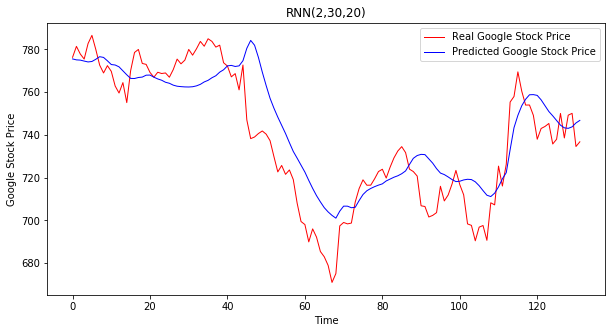

RNN (2, 30, 50) -> MSE: (278.72172732719116)


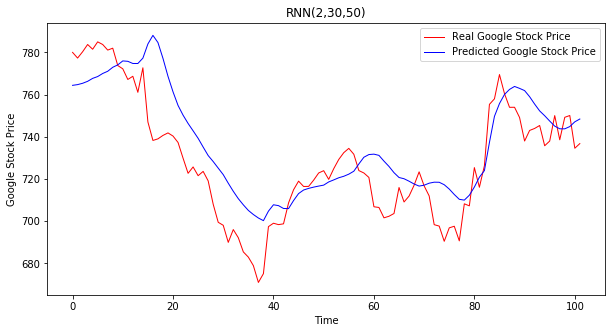

RNN (2, 30, 75) -> MSE: (193.89528207025202)


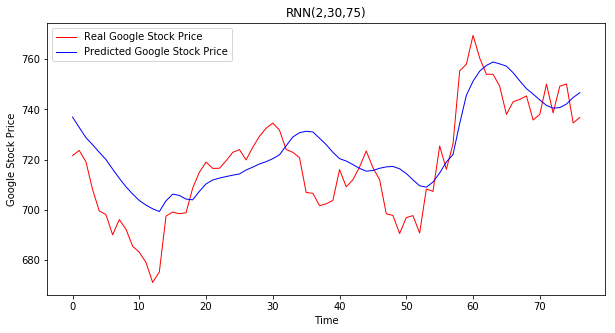

RNN (2, 50, 20) -> MSE: (164.99353751459168)


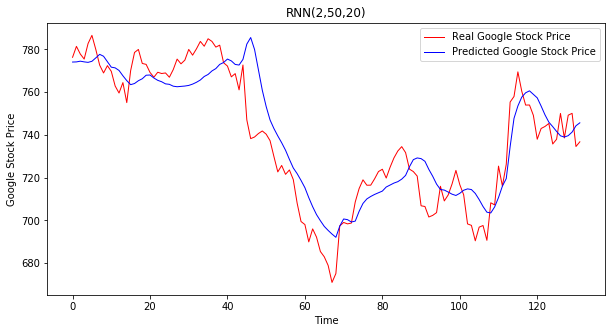

RNN (2, 50, 50) -> MSE: (195.04816602914718)


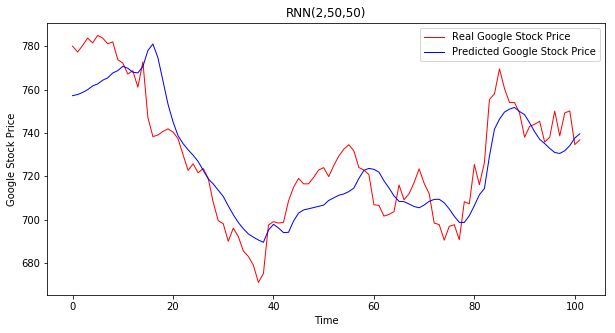

RNN (2, 50, 75) -> MSE: (130.17725107221668)


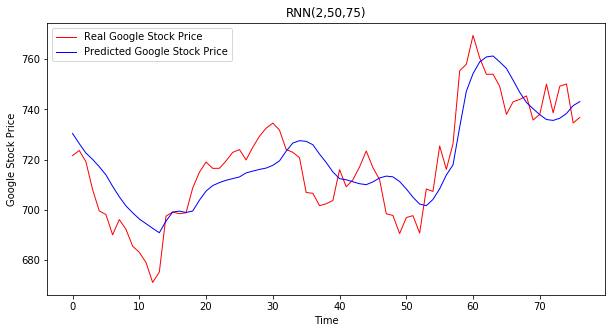

RNN (2, 80, 20) -> MSE: (123.41343109314789)


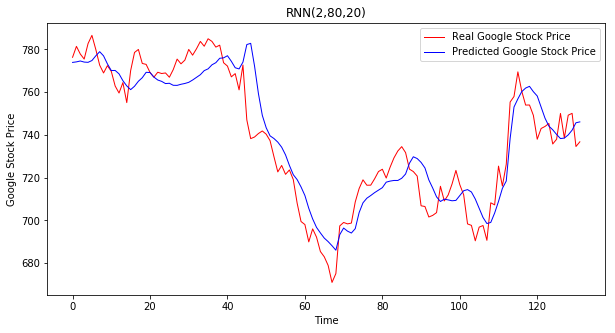

RNN (2, 80, 50) -> MSE: (142.2829753742286)


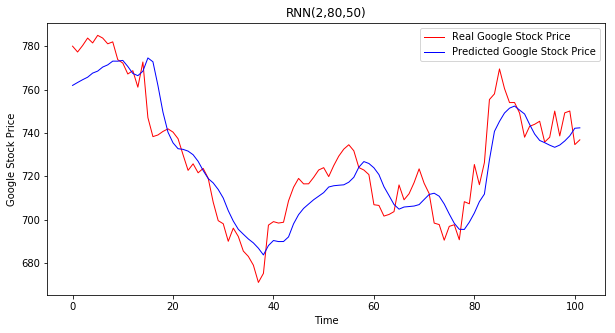

RNN (2, 80, 75) -> MSE: (103.96239139188062)


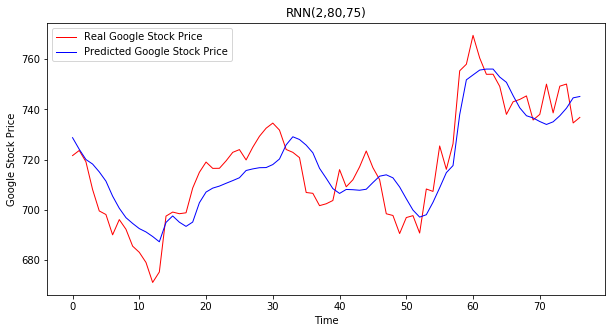

RNN (3, 30, 20) -> MSE: (259.3938585696429)


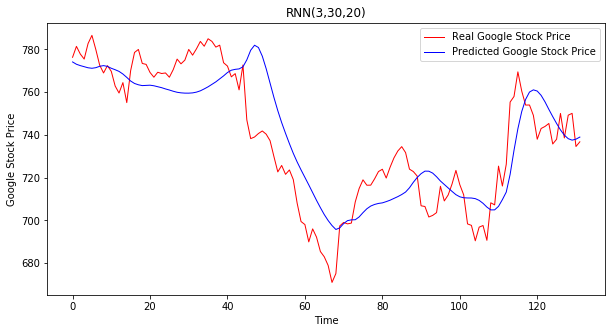

RNN (3, 30, 50) -> MSE: (444.8743565611639)


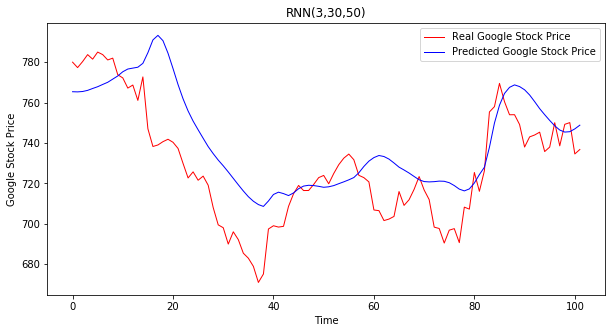

RNN (3, 30, 75) -> MSE: (242.52740255180348)


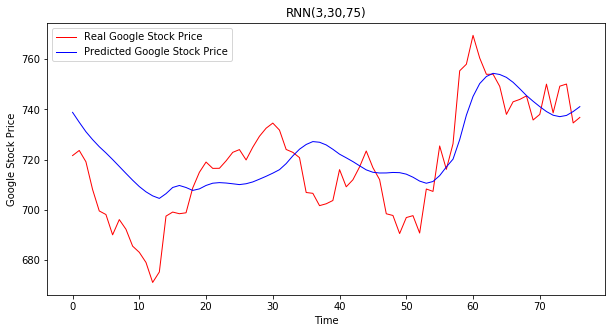

RNN (3, 50, 20) -> MSE: (221.9549699125397)


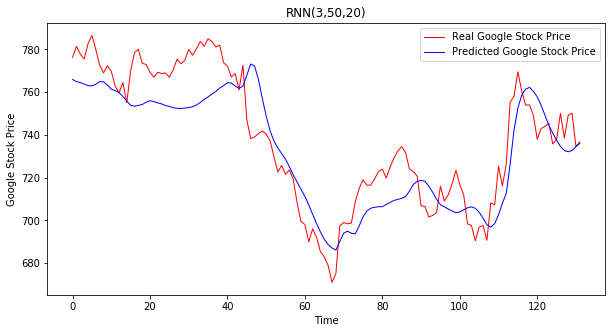

RNN (3, 50, 50) -> MSE: (337.5696813036945)


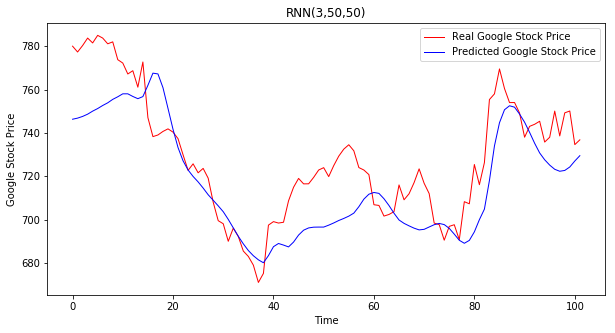

RNN (3, 50, 75) -> MSE: (196.90676717140113)


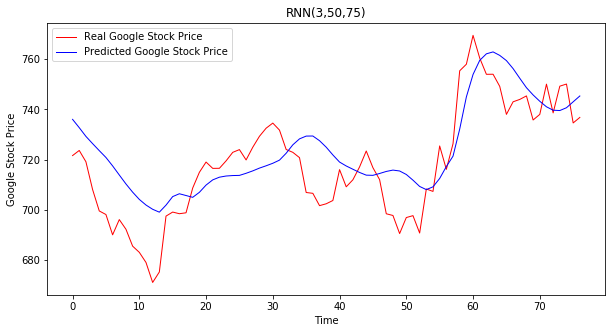

RNN (3, 80, 20) -> MSE: (290.6403780262427)


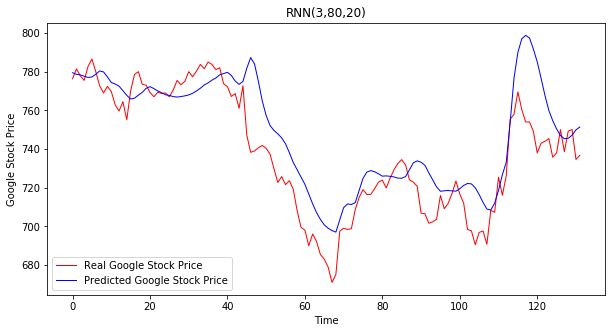

RNN (3, 80, 50) -> MSE: (178.12824481456678)


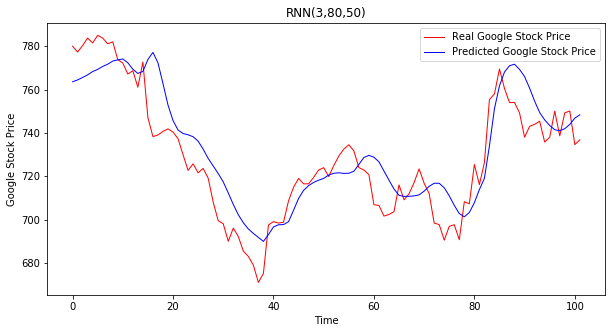

RNN (3, 80, 75) -> MSE: (172.9657958422061)


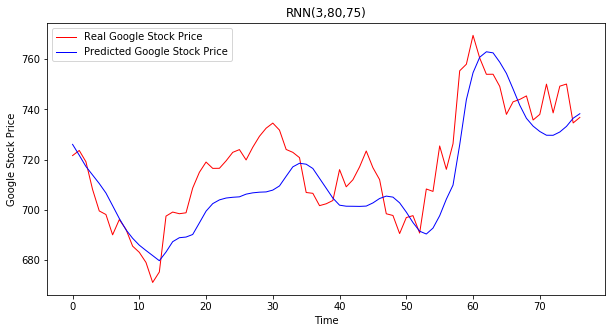

In [509]:
for num_hidden_layers in [2, 3]:
    for num_cells in [30, 50, 80]:
        for num_time_steps in [20, 50, 75]:
            train_x, train_y = preprocess_df(train_df, num_time_steps)
            validation_x, validation_y = preprocess_df(validation_df, num_time_steps)

            # scaling validation_y back to original value
            validation_y = sc_future.inverse_transform(validation_y)

            model = rnn_model_get(num_hidden_layers, num_cells)

            # Compiling the RNN
            model.compile(optimizer = 'adam', loss = 'mean_squared_error')

            # Fitting the RNN to the Training set
            model.fit(train_x, train_y, epochs = EPOCHS, batch_size = BATCH_SIZE, verbose=0)

            # predicting the stock price
            predicted_stock_price = model.predict(validation_x)
            predicted_stock_price = sc_future.inverse_transform(predicted_stock_price)

            print (f"RNN ({num_hidden_layers}, {num_cells}, {num_time_steps}) -> MSE: ({mse(validation_y, predicted_stock_price)})")
            
            draw_time_series_plots(validation_y, predicted_stock_price, num_hidden_layers, num_cells, num_time_steps)

## Part-2: HMM

In [49]:
def all_possible_results_get():
    avg_price_range = np.linspace(0.0, 1, 50)
    volume_range = np.linspace(0.0, 1, 20)
    return np.array(list(itertools.product(avg_price_range, volume_range)))

In [50]:
def features_get(df):
    avg_price = np.array(df['avg'])
    volume = np.array(df['volume'])
    return np.column_stack((avg_price, volume))

In [51]:
def draw_time_series_plots_hmm(validation_y, predicted_avg_price, num_hidden_layers, num_time_steps):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(validation_y, color="red", lw=1, ls='-', label = "Real Google Stock Price");
    ax.plot(predicted_avg_price, color="blue", lw=1, ls='-', label = "Predicted Google Stock Price");
    plt.title("HMM(" + str(num_hidden_layers) + "," + str(num_time_steps) + ")")
    plt.ylabel("Google Stock Price")
    plt.xlabel("Time")
    plt.legend()
    plt.show()

HMM (4, 20) -> MSE: (21543.66499624851)


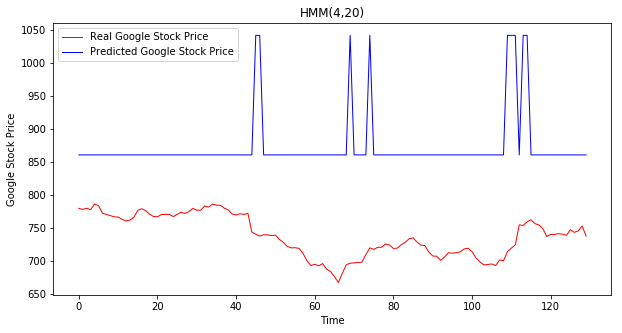

HMM (4, 50) -> MSE: (25652.777028542096)


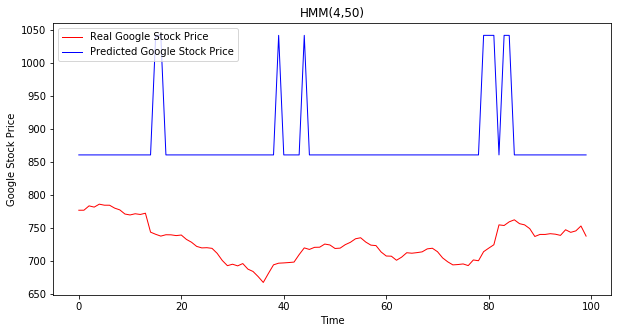

HMM (4, 75) -> MSE: (28525.68127157089)


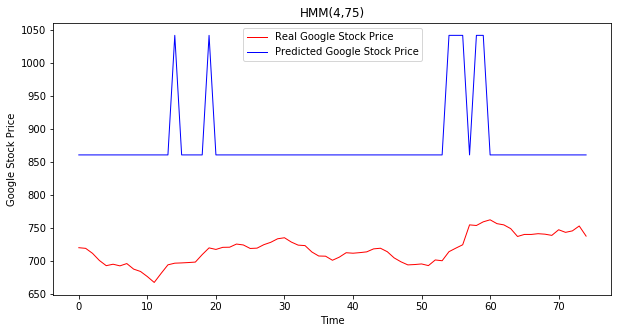

HMM (8, 20) -> MSE: (3833.738439708092)


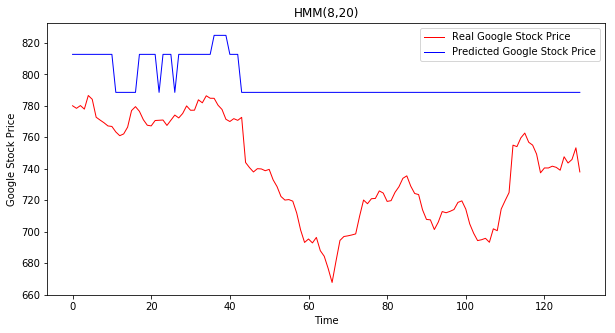

HMM (8, 50) -> MSE: (4611.456395081685)


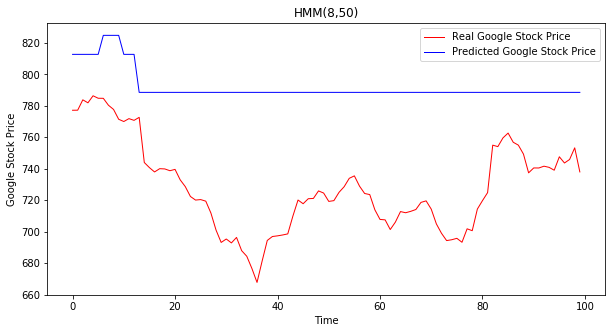

HMM (8, 75) -> MSE: (5455.014654079325)


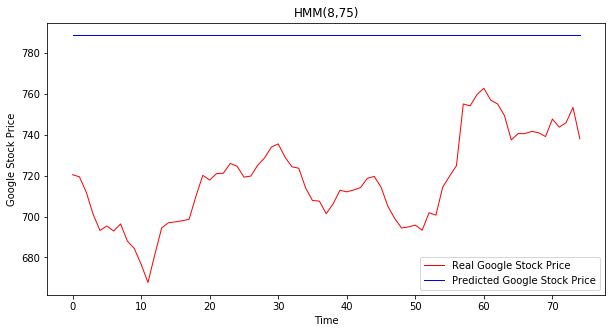

HMM (12, 20) -> MSE: (4318.40793908602)


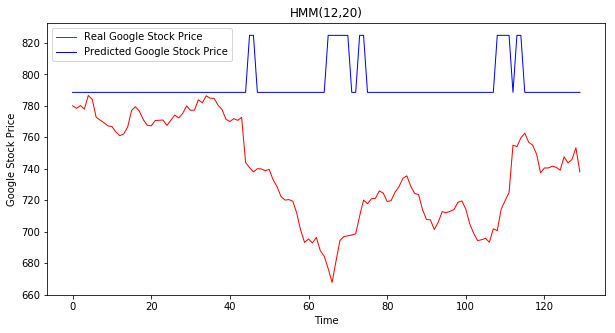

HMM (12, 50) -> MSE: (3120.9042201299303)


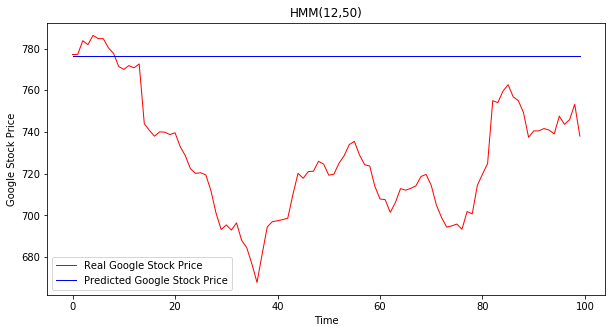

HMM (12, 75) -> MSE: (8430.520382804823)


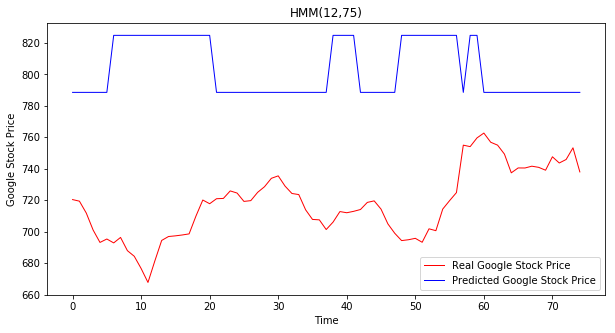

In [53]:
for num_hidden_layers in [4, 8, 12]:
    for num_time_steps in [20, 50, 75]:
        hmm_model = GaussianHMM(n_components=num_hidden_layers)
        
        validation_y = []
        
        possible_results = all_possible_results_get()
        feature_vec = features_get(train_df)
        hmm_model.fit(feature_vec)
        
        pred_avg_prices = []
        for day_idx in range(num_time_steps+1, validation_df.shape[0]):
            validation_y.append(validation_df.iloc[day_idx]['avg'])
            
            st_idx = day_idx - num_time_steps
            end_idx = day_idx - 1
            old_data = validation_df.iloc[st_idx: end_idx]
            old_data_features = features_get(old_data)

            result_score = []
            for result in possible_results:
                complete_data = np.row_stack((old_data_features, result))
                result_score.append(hmm_model.score(complete_data))

            avg_price, pred_volume = possible_results[np.argmax(result_score)]
            pred_avg_prices.append(avg_price)

        pred_avg_prices = np.array([pred_avg_prices]).T
        pred_avg_prices = sc_avg.inverse_transform(pred_avg_prices)
        
        validation_y = np.array([validation_y]).T
        validation_y = sc_avg.inverse_transform(validation_y)
        
        print (f"HMM ({num_hidden_layers}, {num_time_steps}) -> MSE: ({mse(validation_y, pred_avg_prices)})")
        draw_time_series_plots_hmm(validation_y, pred_avg_prices, num_hidden_layers, num_time_steps)

# Q2

In [2]:
e_probs = {}
e_probs["E"] = [0.25] * 4
e_probs["5"] = [0.05, 0, 0.95, 0]
e_probs["I"] = [0.4, 0.1, 0.1, 0.4]

hidden_states = ["E", "5", "I"]
observed_states = ["A", "C", "G", "T"]

emission_probabilities = {}
for h_state in hidden_states:
    emission_probabilities[h_state] = {}
    i = 0
    for obs_state in observed_states:
        emission_probabilities[h_state][obs_state] = e_probs[h_state][i]
        i += 1

In [14]:
transition_probabilities = {}
transition_probabilities["^"] = {}
transition_probabilities["^"]["E"] = 1.0

transition_probabilities["E"] = {}
transition_probabilities["E"]["E"] = 0.9
transition_probabilities["E"]["5"] = 0.1


transition_probabilities["5"] = {}
transition_probabilities["5"]["I"] = 1.0
transition_probabilities["5"]["E"] = 0.0

transition_probabilities["I"] = {}
transition_probabilities["I"]["I"] = 0.9
transition_probabilities["I"]["$"] = 0.1

In [15]:
input_dna_sequence = "CTTCATGTGAAAGCAGACGTAAGTCA"
input_state_path_sequence = "EEEEE5EEEEEEEEEEEE5IIIIIII$"

In [16]:
probability = transition_probabilities["^"]["E"]
for i in range(len(input_dna_sequence)):
    state1 = input_state_path_sequence[i]
    state2 = input_state_path_sequence[i+1]
    obs = input_dna_sequence[i]
    
    e_prob = emission_probabilities[state1][obs]
    t_prob = transition_probabilities[state1][state2]
    
    probability *= e_prob * t_prob

In [17]:
probability

0.0

In [60]:
math.log(probability)

-41.21967768602254